
# **Step 1: Download images of Khinkali and Khachapuri**

In [1]:
#  Install necessary liberairies

!pip install -Uqq duckduckgo_search
!pip install ipywidgets
!pip install fastapi nest-asyncio pyngrok uvicorn
!pip install -Uqq fastbook
!pip install -Uq fastai

     |████████████████████████████████| 96 kB 3.5 MB/s 
     |████████████████████████████████| 62 kB 1.3 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires click<8.0,>=5.1, but you have click 8.1.3 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 5.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 2.7 MB/s 
     |████████████████████████████████| 745 kB 11.3 MB/s 
     |████████████████████████████████| 56 kB 4.7 MB/s 
     |████████████████████████████████| 64 kB 2.5 MB/s 
     |████████████████████████████████| 80 kB 8.7 MB/s 
     |████████████████████████████████| 58 kB 5.5 MB/s 
  Created wheel for pyngrok: filen

In [2]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=200): return L(ddg_images(term, max_results=max_images)).itemgot('image')

Let's search a khinkali photo and see what kind of result we get. Start by getting URLs from a search:



In [3]:
urls = search_images('khinkali photos', max_images=1)
urls[0]

'https://www.innaturale.com/wp-content/uploads/2018/07/Khinkali-Georgia-forma.jpg'

...and then download a URL and take a look at it:

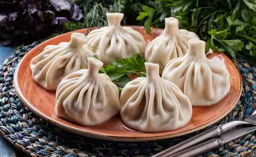

In [4]:
from fastdownload import download_url
dest = 'khinkali.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Now let's do the same with "Khachapuri photos":

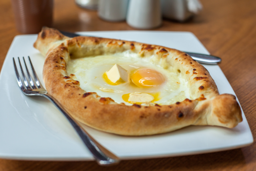

In [5]:
download_url(search_images('khachapuri photos', max_images=1)[0], 'khachapuri.jpg', show_progress=False)
Image.open('khachapuri.jpg').to_thumb(256,256)

Let's grab 200 examples of each of "Khinkali" and "Khachapuri" photos, and save each group of photos to a different folder:



In [6]:
from pathlib import Path

searches = 'khinkali','khachapuri'
path = Path('bird_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:1015: UserWarning: Couldn't allocate palette entry for transparency
  warnings.warn("Couldn't allocate palette entry for transparency")


#**Step 2: Train the model**


Removing the incorrectly downloaded photos, in order to avoid failing the training model

In [7]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

13

DataLoader is an object that contains a training set (the images used to create a model) and a validation set (the images used to check the accuracy of a model -- not used during training). And view sample images from it:

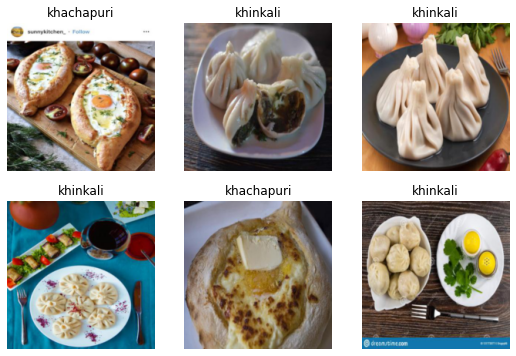

In [11]:
import fastai

dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=6)

In [12]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,0.841049,0.392740,0.108374,01:46


epoch,train_loss,valid_loss,error_rate,time
0,0.253496,0.296676,0.093596,02:29
1,0.170639,0.252315,0.073892,02:30
2,0.115694,0.217663,0.064039,02:30


#**Step 3: Use the model**

In [15]:
is_khinkali,_,probs = learn.predict(PILImage.create('khinkali.jpg'))
print(f"This is a: {is_khinkali}.")
print(f"Probability it's a khinkali: {probs[0]:.4f}")

This is a: khinkali.
Probability it's a khinkali: 0.0000
